In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import healpy as hp
import lsst.sims.maf.db as db
import lsst.sims.maf.metrics as metrics
import lsst.sims.maf.slicers as slicers
import lsst.sims.maf.metricBundles as metricBundles
import lsst.sims.maf.plots as plots
import lsst.sims.maf.utils as utils
from astropy.table import Table, Column
import json

In [2]:
# Establish where the LSST simulations data is coming from, and where output data will go
runName = 'minion_1016'
opsdb = db.OpsimDatabase(runName + '_sqlite.db')
outDir = 'Observations Dictionary'
resultsDb = db.ResultsDb(outDir)

Querying database with no constraint.
Found 2447931 visits
Running:  [0]
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.


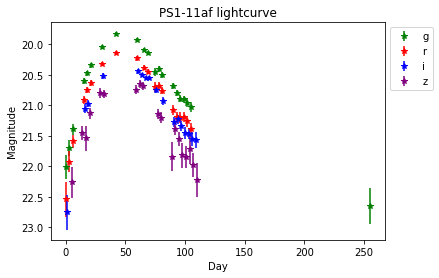

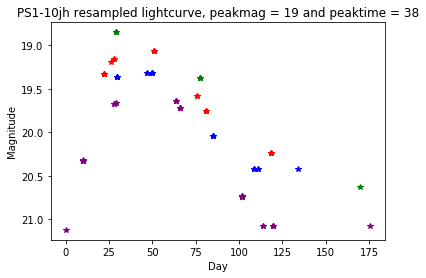

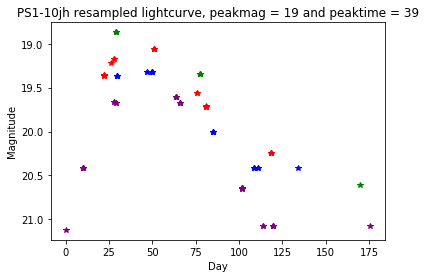

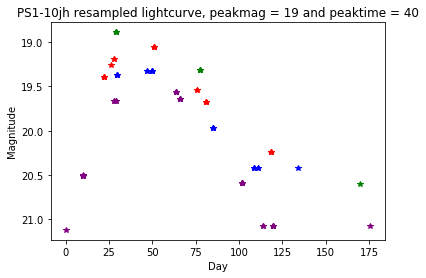

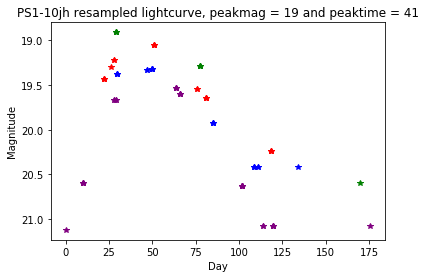

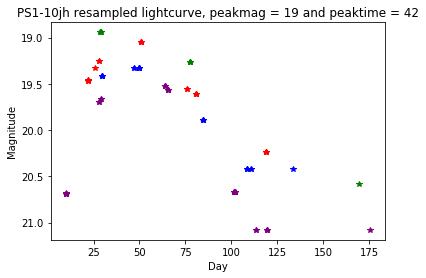

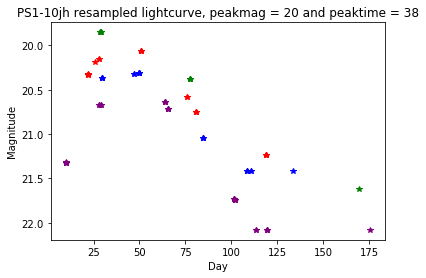

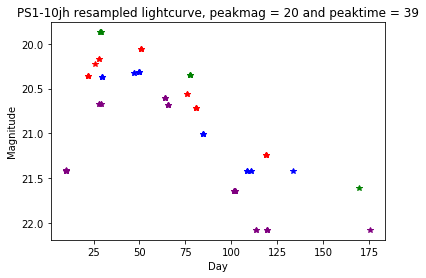

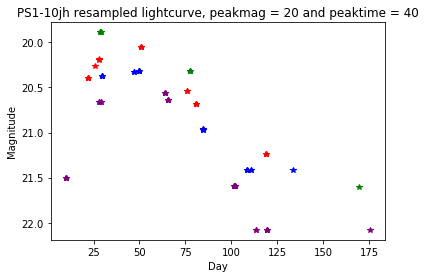

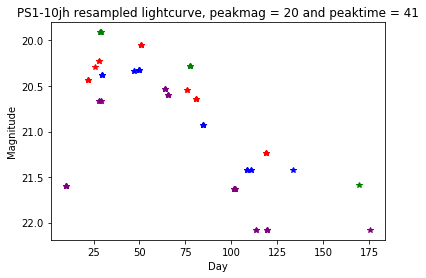

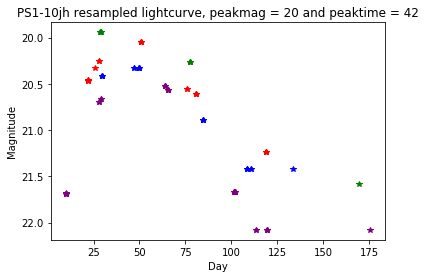

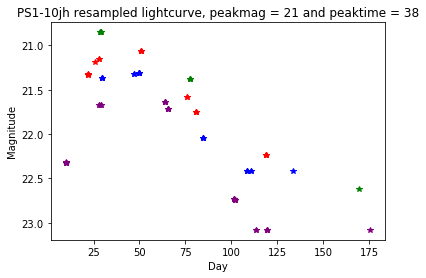

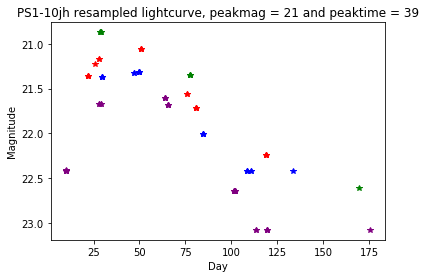

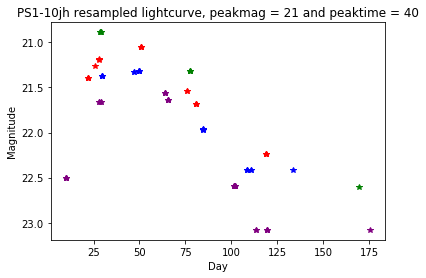

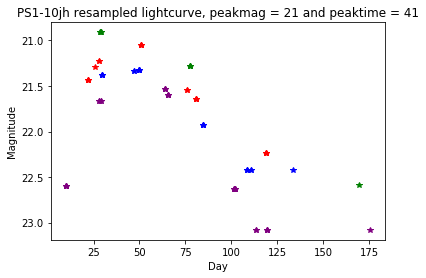

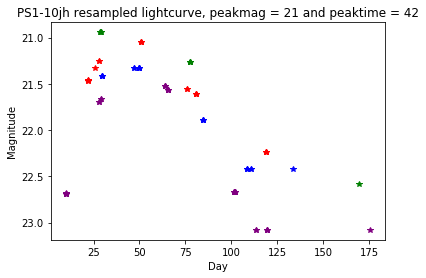

In [4]:
# Set RA, Dec for a single point in the sky. in radians.

ra = np.arange(np.radians(0), np.radians(4), 1)
dec = np.arange(np.radians(0), np.radians(4), 1)
for RA, DEC in ((a,b) for a in ra for b in dec):
    # SNR limit (Don't use points below this limit)
    snrLimit = 5.
    # Demand this many points above SNR limit before plotting LC
    nPtsLimit = 6
    # Establish points of evaluation, how to evaluate (slice) them, and any constraints
    metric = metrics.PassMetric(cols=['expMJD','filter','fiveSigmaDepth'])
    slicer = slicers.UserPointsSlicer(ra,dec)
    sql = ''
    # Run the metric, slicer, and constraint together as a "bundle"
    bundle = metricBundles.MetricBundle(metric,slicer,sql)
    # Group the previous bundle with the data from the LSST simulations
    bg =  metricBundles.MetricBundleGroup({0:bundle}, opsdb, outDir=outDir, resultsDb=resultsDb)
    bg.runAll()

    # Set up dictionary of values and place into table
    bdict = {key: bundle.metricValues[0][key] for key in ['expMJD', 'filter', 'fiveSigmaDepth']}
    opsim = Table(bdict)
    # List the time in terms of day of observation, then sort the days & order the table
    opsim['expMJD'] = opsim['expMJD'] - opsim['expMJD'].min()
    opsim.sort(['expMJD'])
    opsim = opsim['expMJD','filter','fiveSigmaDepth']
    # Only do the following if you need to narrow simulation filters to those matching your lightcurve data
    opsim = opsim[opsim['filter'] != 'u']
    opsim = opsim[opsim['filter'] != 'y']

    # Open and load json file with TDE values
    tde_data = open('PS1-10jh.json')
    tde = json.load(tde_data)
    # Set up dictionary for json data
    data = {'mjd': [], 'filter': [], 'mag': [], 'magerror': [], 'upperlimit': []}
    # Use for loop to call to values within the json file
    for entry in tde['PS1-10jh']['photometry']:
        # Ignore instances in which 'band' and 'magnitude' have no data
        if 'band' in entry and 'magnitude' in entry:
            data['mjd'].append(float(entry['time']))
            data['filter'].append(entry['band'])
            data['mag'].append(float(entry['magnitude']))
            # Ignore instances in which 'upperlimit' has no value (i.e. is 'false')
            if 'upperlimit' in entry:
                data['upperlimit'].append(entry['upperlimit'])
            else:
                data['upperlimit'].append(False)
            # Ignore instances in which 'e_magnitude' has no value (i.e. upperlimit IS the error)
            if 'e_magnitude' in entry:
                data['magerror'].append(float(entry['e_magnitude']))
            else:
                data['magerror'].append(99)
    # Table the now-full dictionary of TDE data
    tde_table = Table(data)
    # Update the table to modify the data for magnitude errors no more than 0.3, no upperlimit values,
    # mjd in terms of obvservation day number, and filters in only g, r, i, and z.
    tde_table = tde_table[tde_table['magerror'] < 0.3]
    tde_table = tde_table[tde_table['upperlimit'] == False]
    tde_table['mjd'] = tde_table['mjd'] - tde_table['mjd'].min()
    tde_table = tde_table[tde_table['filter'] != 'NUV']
    tde_table = tde_table[tde_table['filter'] != 'F225W']

    # Plot the lightcurve from the narrowed points with respect to each filter
    colors = {'g':'green','r':'red','i':'blue','z':'purple'}
    for f in ['g', 'r', 'i', 'z']:
        filter_match = tde_table['filter'] == f
        plt.errorbar(tde_table['mjd'][filter_match], tde_table['mag'][filter_match], 
                     yerr=tde_table['magerror'][filter_match], fmt='*', color=colors[f], label = f)
    plt.ylim(plt.ylim()[::-1])
    plt.title('PS1-11af lightcurve')
    plt.xlabel('Day')
    plt.ylabel('Magnitude')
    plt.legend(loc="upper left", bbox_to_anchor=(1,1))

    peak = {}
    for f in ['g', 'r', 'i', 'z']:
        filter_match = np.where(tde_table['filter'] == f)
        maxmag = np.amin(tde_table['mag'][filter_match])
        row = np.argmin(tde_table['mag'][filter_match])
        maxday = tde_table['mjd'][filter_match][row]
        peak[f] = (maxday, maxmag)
    peak = Table(peak)
    peak[''] = ['peaktime_raw', 'peakmagmag_raw']
    peak = peak['', 'g','r','i','z']

    # Set lowest peak data for new data iterations (based on r-band)
    lowestpeakmag = np.arange(19, 22, 1)
    lowestpeaktime = np.arange(38, 43, 1)
    for mag in lowestpeakmag:
        for day in lowestpeaktime:
            magdiff = peak['r'][1] - mag
            timediff = peak['r'][0] - day
            tde_table['mag'] = tde_table['mag'] - magdiff
            tde_table['mjd'] = tde_table['mjd'] - timediff

            # Setup empty dictionary for interpolated lightcurve 
            tde_lc = {}
            opsim = opsim[opsim['expMJD'] < tde_table['mjd'].max()]
            opsim = opsim[opsim['expMJD'] > tde_table['mjd'].min()]

            # Interpolate lightcurve for days of LSST survey
            for f in ['g', 'r', 'i', 'z']:
                filter_match = np.where(tde_table['filter'] == f)
                tde_lc[f] = np.interp(opsim['expMJD'], tde_table['mjd'][filter_match], tde_table['mag'][filter_match])
            tde_lc = Table(tde_lc)
            tde_lc['mjd'] = opsim['expMJD']
            tde_lc = tde_lc['mjd', 'g', 'r', 'i', 'z']

            # Add a column to the simulation table to include the lightcurve mags, and fill in mag wrt filter
            # This also only finds the data from the lightcurve data in which the "mjd" matches with the simulation
            # Hence this "resamples" the lightcurve
            opsim['magnitude'] = 0.0
            for row in range(len(opsim)):
                filterName = opsim['filter'][row]
                opsim['magnitude'][row] = tde_lc[filterName][row]
            # Find error based off of 5sigDepth, and add it to the table with magnitudes
            snr = 5*(10**((-0.4)*(opsim['magnitude'] - opsim['fiveSigmaDepth'])))
            tde_err2 = 2.5/(snr*np.log(10))
            opsim['tde_err2'] = tde_err2
            plt.figure()
            for f in ['g', 'r', 'i', 'z']:
                filter_match = np.where(opsim['filter'] == f)
                plt.errorbar(opsim['expMJD'][filter_match], opsim['magnitude'][filter_match],
                             color = colors[f], fmt = '*', label = f)
            plt.ylim(plt.ylim()[::-1])
            plt.title('PS1-10jh resampled lightcurve, peakmag = %d and peaktime = %d' % (mag, day))
            plt.xlabel('Day')
            plt.ylabel('Magnitude')
            tde_table['mag'] = tde_table['mag'] + magdiff
            tde_table['mjd'] = tde_table['mjd'] + timediff